In [1]:
import tensorflow as tf

IMAGE_SHAPE = (320, 320, 3)
BATCH_SIZE = 5
DATA_SET_SIZE = 10000

def create_model():
    base_learning_rate = 0.0001
    pretrined_resnet = tf.keras.applications.densenet.DenseNet201(include_top=False, weights='imagenet', input_tensor=None, input_shape=IMAGE_SHAPE, pooling=None, classes=1000)
    pretrined_resnet.trainable = False
    current_layer = pretrined_resnet.output
    current_layer = tf.keras.layers.AveragePooling2D()(current_layer)
    current_layer = tf.keras.layers.Flatten()(current_layer)
    current_layer = tf.keras.layers.Dense(64, activation="relu")(current_layer)
    current_layer = tf.keras.layers.Dropout(0.5)(current_layer)
    current_layer = tf.keras.layers.Dense(2, activation="softmax")(current_layer)
  
    our_model = tf.keras.models.Model(inputs=pretrined_resnet.input, outputs=current_layer)
  
    our_model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate), 
                      loss='binary_crossentropy', metrics=['accuracy'])
    return our_model


In [2]:
import pandas as pd
metadata_train_full = pd.read_csv('CheXpert-v1.0-small/train.csv')
metadata_train_cleaned = metadata_train_full[metadata_train_full['No Finding'] != 1.0]

metadata_valid_full = pd.read_csv('CheXpert-v1.0-small/valid.csv')
metadata_valid = metadata_valid_full[metadata_valid_full['No Finding'] != 1.0]

In [3]:
metadata_train_no = metadata_train_cleaned[metadata_train_cleaned['Pneumonia'] != 1.0][:int(DATA_SET_SIZE/2)]
metadata_train_yes = metadata_train_cleaned[metadata_train_cleaned['Pneumonia'] == 1.0][:int(DATA_SET_SIZE/2)]
metadata_train = pd.concat([metadata_train_no, metadata_train_yes])
metadata_train.count()

Path                          10000
Sex                           10000
Age                           10000
Frontal/Lateral               10000
AP/PA                          7772
No Finding                        0
Enlarged Cardiomediastinum     1690
Cardiomegaly                   1915
Lung Opacity                   6323
Lung Lesion                     806
Edema                          3517
Consolidation                  3350
Pneumonia                      5519
Atelectasis                    2708
Pneumothorax                   2350
Pleural Effusion               5184
Pleural Other                   380
Fracture                        431
Support Devices                4152
dtype: int64

In [4]:
import matplotlib.pyplot as plt
pa_data = metadata_train[metadata_train['AP/PA'].isin(['AP', 'PA'])]
train_pa = metadata_train[metadata_train['AP/PA'].isin(['AP', 'PA'])]
valid_pa = metadata_valid[metadata_valid['AP/PA'].isin(['AP', 'PA'])]

def show_batch(image, label):
    plt.imshow(image)
    print(label)
    

In [5]:
class DataProcessor():
    def __init__(self, from_dataframe):
        self.dataset = tf.data.Dataset.from_tensor_slices((from_dataframe['Path'].values, from_dataframe['Pneumonia'].values))
        for path, lbl in self.dataset.take(1):            
            print(path)
            print(lbl)
    
    def _decode_image(self, img):
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.convert_image_dtype(img, tf.float32)
        return tf.image.resize(img, [IMAGE_SHAPE[0], IMAGE_SHAPE[1]])
    
    def _pre_proces_images(self, file_path, label):
        img = tf.io.read_file(file_path)
        img = self._decode_image(img)
        resulted_label = [0.0, 1.0]
        if label == 1.0:
            resulted_label = [1.0, 0.0]
        return img, resulted_label
    
    def prepare_dataset(self):
        self.dataset = self.dataset.map(self._pre_proces_images)
        self.dataset = self.dataset.cache()
        self.dataset = self.dataset.shuffle(buffer_size = DATA_SET_SIZE+1, reshuffle_each_iteration=True )
        self.dataset = self.dataset.repeat()
        self.dataset = self.dataset.batch(BATCH_SIZE)
        self.dataset = self.dataset.prefetch(buffer_size= tf.data.experimental.AUTOTUNE)
        
        return self.dataset

train_ds = DataProcessor(from_dataframe = train_pa).prepare_dataset()
valid_ds = DataProcessor(from_dataframe = valid_pa).prepare_dataset()

tf.Tensor(b'CheXpert-v1.0-small/train/patient00002/study2/view1_frontal.jpg', shape=(), dtype=string)
tf.Tensor(nan, shape=(), dtype=float64)
tf.Tensor(b'CheXpert-v1.0-small/valid/patient64541/study1/view1_frontal.jpg', shape=(), dtype=string)
tf.Tensor(0.0, shape=(), dtype=float64)


tf.Tensor([0. 1.], shape=(2,), dtype=float32)


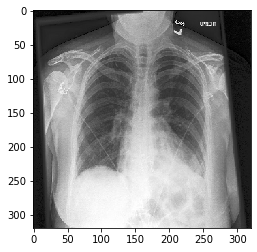

In [6]:
for image, label in train_ds.take(1):
    show_batch(image[0], label[0])

In [7]:
current_model = create_model()

In [12]:
history_mobile = current_model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=150,
    steps_per_epoch  = 200,
    validation_steps = 20
)

Train for 200 steps, validate for 20 steps
Epoch 1/150
200/200 [==============================] - 16s 78ms/step - loss: 0.6241 - accuracy: 0.6390 - val_loss: 0.9944 - val_accuracy: 0.1600
Epoch 2/150
200/200 [==============================] - 15s 73ms/step - loss: 0.6305 - accuracy: 0.6390 - val_loss: 0.6898 - val_accuracy: 0.6600
Epoch 3/150
200/200 [==============================] - 15s 73ms/step - loss: 0.6302 - accuracy: 0.6200 - val_loss: 0.6528 - val_accuracy: 0.7300
Epoch 4/150
200/200 [==============================] - 15s 73ms/step - loss: 0.6214 - accuracy: 0.6270 - val_loss: 1.7323 - val_accuracy: 0.0400
Epoch 5/150
200/200 [==============================] - 15s 74ms/step - loss: 0.6238 - accuracy: 0.6600 - val_loss: 0.7019 - val_accuracy: 0.6100
Epoch 6/150
200/200 [==============================] - 15s 73ms/step - loss: 0.6359 - accuracy: 0.6230 - val_loss: 0.6873 - val_accuracy: 0.6500
Epoch 7/150
200/200 [==============================] - 15s 73ms/step - loss: 0.6254 - a

In [9]:

current_model.save_weights('as_densenet201_pneumonia_0510.h5')

In [10]:
for file_name in valid_pa[valid_pa['Pneumonia'] == 1.0][:100]['Path'].tolist():
    img = tf.io.read_file(file_name)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [IMAGE_SHAPE[0], IMAGE_SHAPE[1]])
    img_input = tf.expand_dims(img, 0)
    result = current_model.predict(img_input)
    print(result)

[[0.4940719 0.5059281]]
[[0.48753008 0.51246995]]
[[0.5003355  0.49966446]]
[[0.52143204 0.47856796]]
[[0.5076723  0.49232766]]
[[0.48626122 0.5137388 ]]
[[0.5228017  0.47719836]]
[[0.49749035 0.50250965]]
